# LTU-ILI: Append dummy data test

Author: 
  - [@CompiledAtBirth](https://github.com/CompiledAtBirth) (Nicolas Chartier)

### Overview
(TODO)
Append dummy data test with Latin Hypercube statistics from the Quijote simulations

In [2]:
!pip install --upgrade --quiet sbi chainconsumer netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
# Other possibility: uppload files with GUI from computer
#from google.colab import files
#files.upload()

In [3]:
# Load the Drive helper and mount
from google.colab import drive
help(drive)

Help on module google.colab.drive in google.colab:

NAME
    google.colab.drive - Colab-specific Google Drive integration.

FUNCTIONS
    flush_and_unmount(timeout_ms=86400000)
        Unmount Google Drive and flush any outstanding writes to it.
    
    mount(mountpoint, force_remount=False, timeout_ms=120000, readonly=False)
        Mount your Google Drive at the specified mountpoint path.

DATA
    __all__ = ['flush_and_unmount', 'mount']

FILE
    /usr/local/lib/python3.9/dist-packages/google/colab/drive.py




In [4]:
# This will prompt for authorization.
#drive.mount('/content/drive/MyDrive/ColabNotebooks/Data/') # mounting a specific subfolder does not work
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [5]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
dataDir =  "/content/drive/MyDrive/ColabNotebooks//LTU_ILI/Data/quijote_z0p5"
!ls $dataDir

Bk  latin_hypercube_params.txt	Pk


In [109]:
import numpy as np
import copy
import netCDF4 as nc
import matplotlib.pyplot as plt

# see Interface Usage examples at eg. https://www.mackelab.org/sbi/tutorial/02_flexible_interface/
import torch
from sbi import utils as utils
from sbi.inference import SNPE, SNLE, likelihood_estimator_based_potential, MCMCPosterior

from chainconsumer import ChainConsumer

In [110]:
# Setting pyTorch device as GPU if available, else CPU
deviceStr = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(deviceStr)
print('Using device:', device)

Using device: cuda


In [7]:
# Sanity check sbi (from documentatiomn)
from sbi.examples.minimal import simple
posterior = simple()
print(posterior)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 47 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [111]:
#%% Playing around with .nc files from quijote_LH (2000 Latin Hypercube simulations without massive neutrinos)
# quijote_nwLH would be with massive neutrinos
paramStr=[r"$\Omega_m$", r"$\Omega_b$",r"$h$",r"$n_s$",r"$\sigma_8$",r"$w$"]

# Means are Quijote fiducial parameters, for the standard deviations I checked some literature
Om0 = 0.3175 ; s_Om0 = 0.0074
Ob0 = 0.049 ; s_Ob0 = 0.0003
h = 0.6711 ; s_h = 0.0054
n_s = 0.9424 ; s_ns = 0.0042
sigma_8 = 0.834 ; s_sigma_8 = 0.006
w = -1.0 ; s_w = 0.05

fiducial = np.array([Om0,Ob0,h,n_s,sigma_8,w])
factVariance = 1.0 # if we want to make Planck-like uncertainties wider or thiner for Gaussian prior

# Arbitrary constraints parametrized with standard deviations for the test, should be more realistic given the cosmology literature
constraints = factVariance * np.array([s_Om0**2,s_Ob0**2,s_h**2,s_ns**2,s_sigma_8**2,s_w**2])
theta = np.float32(np.loadtxt(dataDir + "/latin_hypercube_params.txt", delimiter = " ", skiprows = 1))

# axis along which RSD has been computed
axRSD = 0

# Data Files
filePk = "PK_z0p5_RSD%i_kmax1p0.nc"%axRSD
fileBk = "LH_Bk_RSD%i_iso.h5"%axRSD # iso for isosceles triangles only
#k3D = np.float32(np.loadtxt(dataDir + "/../k3D_quijote.txt"))

In [112]:
# Explore .nc format as training
pkData = nc.Dataset(dataDir  + "/Pk/" + filePk)

# Individual dimensions are accessed via dat1.dimensions['x']
for group in pkData.groups.values():
    print(group)

<class 'netCDF4._netCDF4.Group'>
group /LH_z0p5:
    dimensions(sizes): Seed(2000), multipole(3), k3D(158)
    variables(dimensions): float64 k3D(k3D), int64 multipole(multipole), int64 Seed(Seed), float64 PkRSD_ax0(Seed, multipole, k3D)
    groups: 
<class 'netCDF4._netCDF4.Group'>
group /fiducial_z0p5:
    dimensions(sizes): Seed(500), multipole(3), k3D(158)
    variables(dimensions): float64 k3D(k3D), int64 multipole(multipole), int64 Seed(Seed), float64 PkRSD_ax0(Seed, multipole, k3D)
    groups: 


In [113]:
pkLH = pkData["LH_z0p5"]
pkFid = pkData["fiducial_z0p5"]

# if we just just use Dataset.dimensions, just the names are shown without details
for dim in pkLH.dimensions.values():
  print(dim)

k3D = pkLH["k3D"]
ells = pkLH["multipole"]
seedsLH = pkLH["Seed"]
seedsFid = pkFid["Seed"]
print(len(seedsLH))
print(len(seedsFid))
print(pkLH["PkRSD_ax%i"%axRSD].shape)

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Seed', size = 2000
<class 'netCDF4._netCDF4.Dimension'>: name = 'multipole', size = 3
<class 'netCDF4._netCDF4.Dimension'>: name = 'k3D', size = 158
2000
500
(2000, 3, 158)


In [114]:
# Retrieve LH dataset as an array
pkLH_ell = pkLH["PkRSD_ax%i"%axRSD][:,ells==axRSD,:]
print(pkLH_ell.shape)
print(seedsLH[:])

# Idem for fiducial dataset, which we will use to compute fake observed data to evaluate a trained posterior
pkFid_ell = pkFid["PkRSD_ax%i"%axRSD][:,ells==axRSD,:]
pk0 = torch.from_numpy(np.mean(pkFid_ell, axis = 0)).to(dtype = torch.float32, device = deviceStr)
#pk0 = torch.from_numpy(np.loadtxt(dataDir + "/pkFid_RSD0.txt")).to(dtype = torch.float32, device = device)
pk0.get_device() # should return 0 for a GPU tensor because the function returns -1 for cpu tensiors

(2000, 158)
[   0    1    2 ... 1997 1998 1999]


0

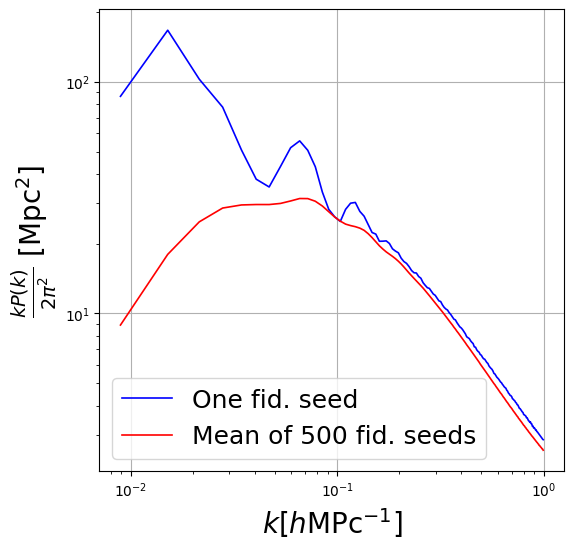

In [116]:
# Plot Pk monopole example and the fiducial mean for illustration
seedExample = 4
pkTest = pkLH_ell[seedExample,:]

plt.figure(figsize=(6,6))
plt.loglog(k3D[:], k3D[:]/(2*np.pi**2)*pkTest, linewidth=1.2, color = "blue", label = "One fid. seed")
plt.loglog(k3D[:],  k3D[:]/(2*np.pi**2)*pk0.cpu().numpy(), linewidth=1.2, color = "red", label = "Mean of %i fid. seeds"%pkFid_ell.shape[0])
plt.xlabel(r'$k [h \rm{MPc}^{-1}]$',fontsize=20)
plt.ylabel(r"$\frac{kP(k)}{2\pi^2}$ $[{\rm Mpc^{2}}]$",fontsize = 20)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 18, loc = "best")
plt.grid()

In [117]:
# Let's do an inference test on Om, sigma8 and h only for the moment
chosenStr = [r"$\Omega_m$",r"$h$",r"$\sigma_8$"]
res = [i for i, val in enumerate(paramStr) if val in set(chosenStr)]
print(fiducial[res])

# Use correct dtype for torch and sbi, the later needs float32 torch tensors!

# In case we use a multivariate normal (MVN) prior, setup mean and covariance matrix
meanPrior = torch.from_numpy(fiducial[res]).to(dtype = torch.float32,device = device)
covPrior = torch.from_numpy(constraints[res] * np.eye(len(chosenStr))).to(dtype = torch.float32, device = device)

# Prepare precomputed simulation-data pairs for sbi inference instances
# CAREFUL: Normally one would have of course to check the order of samples in pkTorch matches the parameters in thetaTorch!
# In the .nc file I already filled the variable corresponding to pk in order of the seeds
myTheta  = theta [:,res]
thetaTorch = torch.from_numpy(myTheta).to(dtype =torch.float32, device = device)
pkTorch = torch.from_numpy(pkLH_ell).to(dtype = torch.float32, device = device)

[0.3175 0.6711 0.834 ]


In [129]:
# A bit more customization than the high level interface of sbi
# Here we specify e neural net targeting the posterior for SNPE
# for more detail with MAF, check the function build_maf in sbi/sbi/neural_nets/flow.py
typeDE = "maf" # Masked Autoregressive flows
nHidden = 100 # default is 50
numT= 5 # number of MADEs, default is 5 for maf
dropoutRate = 0.3 # the high-level sbi functions set this to 0.0 by default
batchNorm = False # use_batch_norm is set to False by default in high-level sbi
activationType = torch.tanh # default of high-level sbi is torch.tanh for buld_maf

densityEst = utils.get_nn_models.posterior_nn(model = typeDE, hidden_features = nHidden, num_transforms = numT, 
                                           activation = activationType,
                                           dropout_probability = dropoutRate, use_batch_norm = batchNorm)

In [130]:
# Setup inference: priors
num_dim = len(res)
priorMVN = torch.distributions.MultivariateNormal(meanPrior, covPrior)
priorU = utils.BoxUniform(low=0.0 * torch.ones(num_dim,device = "cuda"), 
                          high=1.0 * torch.ones(num_dim, device = "cuda"),device = "cuda")


# We use SNPE here; check literature about SNLE and SNPE
inferenceMVN = SNPE(prior=priorMVN, density_estimator = densityEst, show_progress_bars=True, device = "cuda")
inferenceU = SNPE(prior=priorU, density_estimator = densityEst, show_progress_bars=True, device = "cuda")
#inference = SNLE(density_estimator = densityEst, show_progress_bars=True,device = "cuda")

# Example when using pre-simulated data for training
myInferenceMVN = inferenceMVN.append_simulations(thetaTorch, pkTorch)
myInferenceU = inferenceU.append_simulations(thetaTorch, pkTorch)

/usr/local/lib/python3.9/dist-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [131]:
#%% Training the models
density_estimatorMVN = myInferenceMVN.train()
density_estimatorU = myInferenceU.train()

# Priors are added at the build_posterior stage for SNLE, here we use SNPE
posteriorMVN = inferenceMVN.build_posterior(density_estimatorMVN)
posteriorU = inferenceU.build_posterior(density_estimatorU)

 Neural network successfully converged after 156 epochs.

In [132]:
print(dir(myInferenceMVN))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% \n NEURAL NET SUMMARY \n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(myInferenceMVN._neural_net)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% \n INFERENCE MVN PRIOR \n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(myInferenceMVN.summary)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% \n INFERENCE UNIFORM PRIOR \n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(myInferenceU.summary)

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_automatic_posterior_transformation', '_best_model_state_dict', '_best_val_log_prob', '_build_neural_net', '_check_proposal', '_converged', '_data_round_index', '_default_summary_writer', '_describe_round', '_device', '_epochs_since_last_improvement', '_log_prob_proposal_posterior', '_log_prob_proposal_posterior_atomic', '_log_prob_proposal_posterior_mog', '_logits_proposal_posterior', '_loss', '_maybe_show_progress', '_maybe_z_score_theta', '_means_proposal_posterior', '_model_bank', '_neural_net', '_num_atoms', '_posterior', '_precisions_proposal_posterior', '_prio

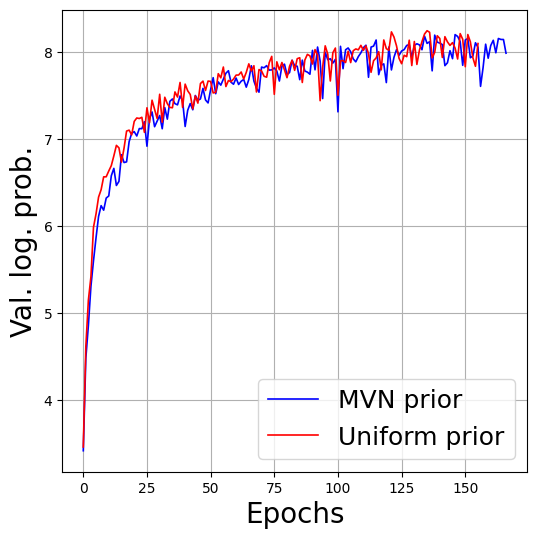

In [133]:
plt.figure(figsize=(6,6))
plt.plot(myInferenceMVN.summary["validation_log_probs"], linewidth=1.2, color = "blue", label = "MVN prior")
plt.plot(myInferenceU.summary["validation_log_probs"], linewidth=1.2, color = "red", label = "Uniform prior")
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Val. log. prob.",fontsize = 20)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 18, loc = "best")
plt.grid()

In [134]:
# Let's pretend the observed data is the mean of my theoretical predictions
posteriorMVN_samples = posteriorMVN.sample((100000,), x=pk0)
posteriorU_samples = posteriorU.sample((100000,), x=pk0)

# OLD : keep lines below as examples
# x0 = torch.from_numpy(np.loadtxt("PkFiducial_z0p5_kmax1p0.txt")).to(torch.float32) ## COMPLETELY MESSES UP THE INFERENCE, PERHAPS BECAUSE I THOUGH USING THE REAL SPACE PK WAS EQUIVALENT TO THE RSD angular PK MOMOPOLE LOL
#posteriorMVN.set_default_x(pk0) # which x0
#posteriorU.set_default_x(pk0) # which x0

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

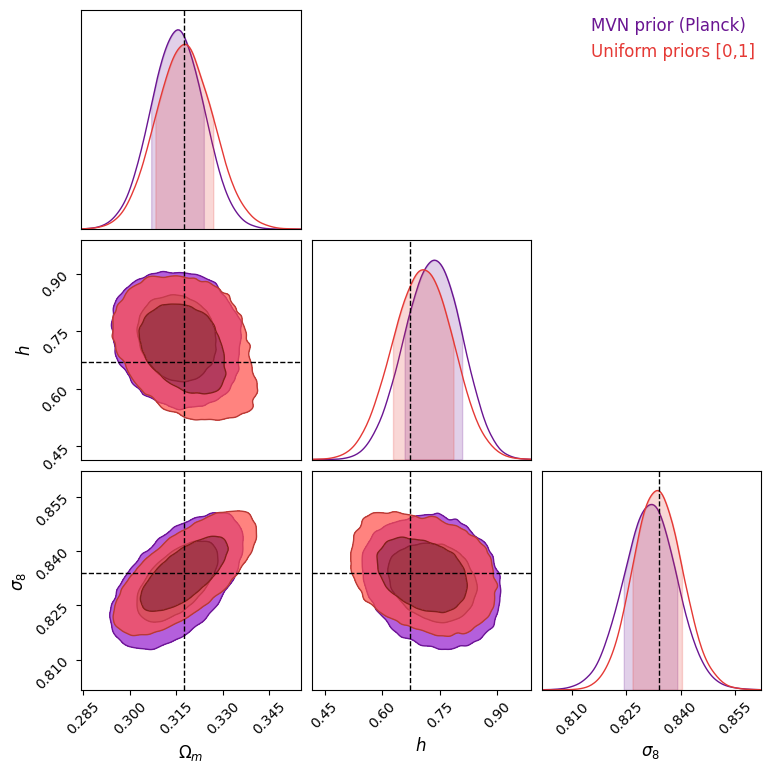

In [135]:
cornerPlotSize = 8
c1 = ChainConsumer()

c1.configure(usetex = True,serif = True, shade=[True, True], shade_alpha=[1.0, 1.0,1.0, 1.0, 1.0], bar_shade=False,
            diagonal_tick_labels=True, tick_font_size=18, label_font_size=25, max_ticks=3,
            legend_kwargs={"loc": "upper right", "fontsize": 30},
            legend_color_text=True)

c1.add_chain(posteriorMVN_samples.cpu().numpy(), parameters = chosenStr, name = "MVN prior (Planck)", zorder = 1, color="#6A1592")
c1.add_chain(posteriorU_samples.cpu().numpy(), parameters = chosenStr, name = "Uniform priors [0,1]", zorder = 2, color = "red")
fig = c1.plotter.plot(figsize  =(cornerPlotSize,cornerPlotSize),truth=fiducial[res])

## LTU-ILI: Now test with added noise, independent of parameters

We are also going to see if shuffling the elements of the "data+noise" vector completely impedes the inference capabilities

In [139]:
# Generate random multivariate noise to concatenate to the Power spectrum data
#   S for small, M for medium...
np.random.seed(42)
ratioNoiseM = 1.0
ratioNoiseS = 0.2
dimNoiseM = int(np.floor(ratioNoiseM*len(k3D)))
dimNoiseS = int(np.floor(ratioNoiseS*len(k3D)))
noiseArrM = np.zeros((2000,dimNoiseM), dtype = float)
noiseArrS = np.zeros((2000,dimNoiseS), dtype = float)

for n in range(len(seedsLH[:])):
  noiseArrM[n,:] = np.random.multivariate_normal(np.pi*np.ones((dimNoiseM,)),np.pi/2.0 * np.eye(dimNoiseM))
  noiseArrS[n,:] = np.random.multivariate_normal(np.pi*np.ones((dimNoiseS,)),np.pi/2.0 * np.eye(dimNoiseS))

# First vector: Pk + noise, concatenated
pkPlusNoiseM = np.concatenate((pkLH_ell, noiseArrM), axis = 1)
pkPlusNoiseS = np.concatenate((pkLH_ell, noiseArrS), axis = 1)

# Second vector: Pk + noise, concatenated and shuffled
seedShuffle = 9
pkPlusNoise_shM = np.concatenate((pkLH_ell, noiseArrM), axis = 1).T
pkPlusNoise_shS = np.concatenate((pkLH_ell, noiseArrS), axis = 1).T
print(pkPlusNoise_shM.shape)

np.random.seed(seedShuffle)
np.random.shuffle(pkPlusNoise_shM)
pkPlusNoise_shM = pkPlusNoise_shM.T
print(pkPlusNoise_shM.shape)

np.random.seed(seedShuffle)
np.random.shuffle(pkPlusNoise_shS)
pkPlusNoise_shS = pkPlusNoise_shS.T

# Do not forget to shuflle the parameters accordingly!
thetaNoise = copy.copy(myTheta).T
np.random.seed(seedShuffle)
np.random.shuffle(thetaNoise)
thetaNoise = thetaNoise.T

(316, 2000)
(2000, 316)


In [140]:
# Redo the analysis with pkPlus noise
pkPlusNoiseTorchM = torch.from_numpy(pkPlusNoiseM).to(dtype= torch.float32, device  = device)
pkPlusNoiseTorchS = torch.from_numpy(pkPlusNoiseS).to(dtype= torch.float32, device  = device)
pkPlusNoiseTorch_shM = torch.from_numpy(pkPlusNoise_shM).to(dtype= torch.float32, device  = device)
pkPlusNoiseTorch_shS = torch.from_numpy(pkPlusNoise_shS).to(dtype= torch.float32, device  = device)

thetaTorchNoise = torch.from_numpy(thetaNoise).to(dtype =torch.float32, device = device)

# Possibility to change the density estimator for Pk + noise
nHiddenNoise = 100 # default is 50
numTNoise= 5 # number of MADEs, default is 5 for maf
#nHiddenNoiseM = 100 # default is 50
#numTNoiseM= 6 # number of MADEs, default is 5 for maf

densityEstNoise = utils.get_nn_models.posterior_nn(model = typeDE, hidden_features = nHiddenNoise, num_transforms = numTNoise, 
                                           activation = activationType,
                                           dropout_probability = dropoutRate, use_batch_norm = batchNorm)
#densityEstNoiseM = utils.get_nn_models.posterior_nn(model = typeDE, hidden_features = nHiddenNoiseM, num_transforms = numTNoiseM, 
 #                                          activation = activationType,
 #                                          dropout_probability = dropoutRate, use_batch_norm = batchNorm)

# We stick to Uniform priors [0,1] from now on, using SNPE
inferenceNoiseM = SNPE(prior=priorU, show_progress_bars=True, device = "cuda", density_estimator = densityEstNoise)
inferenceNoiseS = SNPE(prior=priorU , show_progress_bars=True, device = "cuda", density_estimator = densityEstNoise)
inferenceNoise_shM = SNPE(prior=priorU, show_progress_bars=True, device = "cuda", density_estimator = densityEstNoise)
inferenceNoise_shS = SNPE(prior=priorU , show_progress_bars=True, device = "cuda", density_estimator = densityEstNoise)

# Example when using pre-simulated data for training
myInferenceNoiseM = inferenceNoiseM.append_simulations(thetaTorch, pkPlusNoiseTorchM)
myInferenceNoiseS = inferenceNoiseS.append_simulations(thetaTorch, pkPlusNoiseTorchS)
myInferenceNoise_shM = inferenceNoise_shM.append_simulations(thetaTorchNoise, pkPlusNoiseTorch_shM) # Use shuffled theta here !!
myInferenceNoise_shS = inferenceNoise_shS.append_simulations(thetaTorchNoise, pkPlusNoiseTorch_shS)

#%% Parametric model for the posterior
density_estimatorNoiseM = myInferenceNoiseM.train()
density_estimatorNoiseS = myInferenceNoiseS.train()
density_estimatorNoise_shM = myInferenceNoise_shM.train()
density_estimatorNoise_shS = myInferenceNoise_shS.train()

/usr/local/lib/python3.9/dist-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 85 epochs.

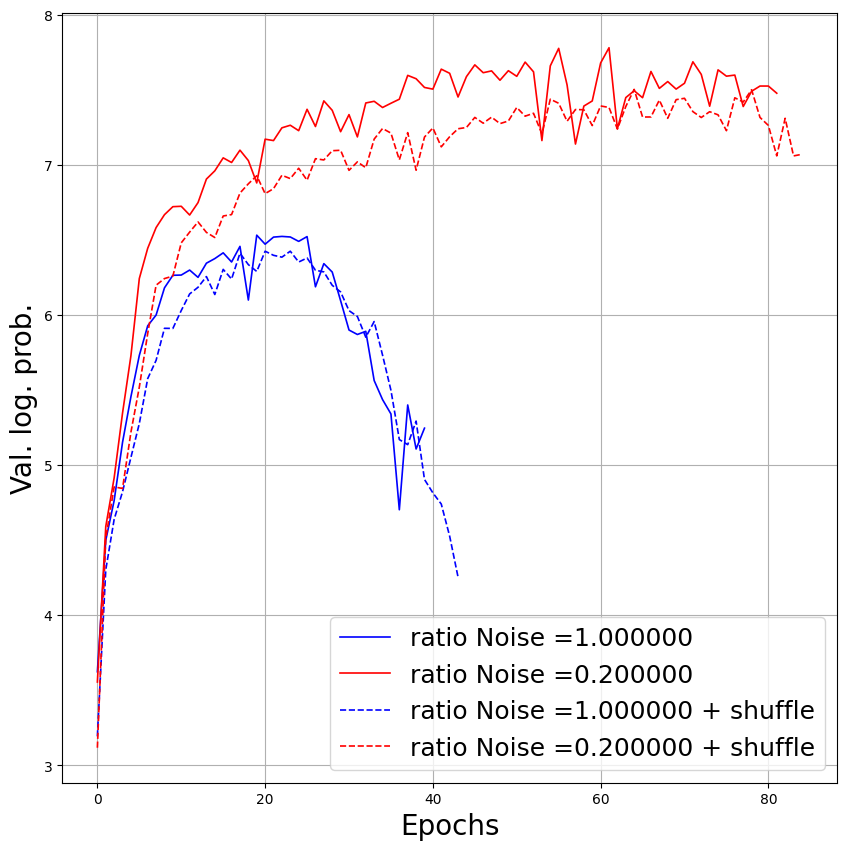

In [141]:
plt.figure(figsize=(10,10))
plt.plot(myInferenceNoiseM.summary["validation_log_probs"], linewidth=1.2, color = "blue", label = "ratio Noise =%f"%ratioNoiseM)
plt.plot(myInferenceNoiseS.summary["validation_log_probs"], linewidth=1.2, color = "red", label = "ratio Noise =%f"%ratioNoiseS)
plt.plot(myInferenceNoise_shM.summary["validation_log_probs"], linewidth=1.2, color = "blue",linestyle = "dashed", label = "ratio Noise =%f + shuffle"%ratioNoiseM)
plt.plot(myInferenceNoise_shS.summary["validation_log_probs"], linewidth=1.2, color = "red",linestyle = "dashed", label = "ratio Noise =%f + shuffle"%ratioNoiseS)
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Val. log. prob.",fontsize = 20)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 18, loc = "best")
plt.grid()

In [142]:
# Let's see if having begger networks improve the M cases
nHiddenNoiseBig = 180 # default is 50
numTNoiseBig= 8 # number of MADEs, default is 5 for maf
dropoutRateBig = 0.4

densityEstNoiseBig = utils.get_nn_models.posterior_nn(model = typeDE, hidden_features = nHiddenNoiseBig, num_transforms = numTNoiseBig, 
                                           activation = activationType,
                                           dropout_probability = dropoutRateBig, use_batch_norm = batchNorm)

inferenceNoiseMBig = SNPE(prior=priorU, show_progress_bars=True, device = "cuda", density_estimator = densityEstNoiseBig)
inferenceNoise_shMBig = SNPE(prior=priorU, show_progress_bars=True, device = "cuda", density_estimator = densityEstNoiseBig)

# Example when using pre-simulated data for training
myInferenceNoiseMBig = inferenceNoiseMBig.append_simulations(thetaTorch, pkPlusNoiseTorchM)
myInferenceNoise_shMBig = inferenceNoise_shMBig.append_simulations(thetaTorchNoise, pkPlusNoiseTorch_shM) # Use shuffled theta here !!

#%% Parametric model for the posterior
density_estimatorNoiseMBig = myInferenceNoiseMBig.train()
density_estimatorNoise_shMBig = myInferenceNoise_shMBig.train()

/usr/local/lib/python3.9/dist-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 40 epochs.

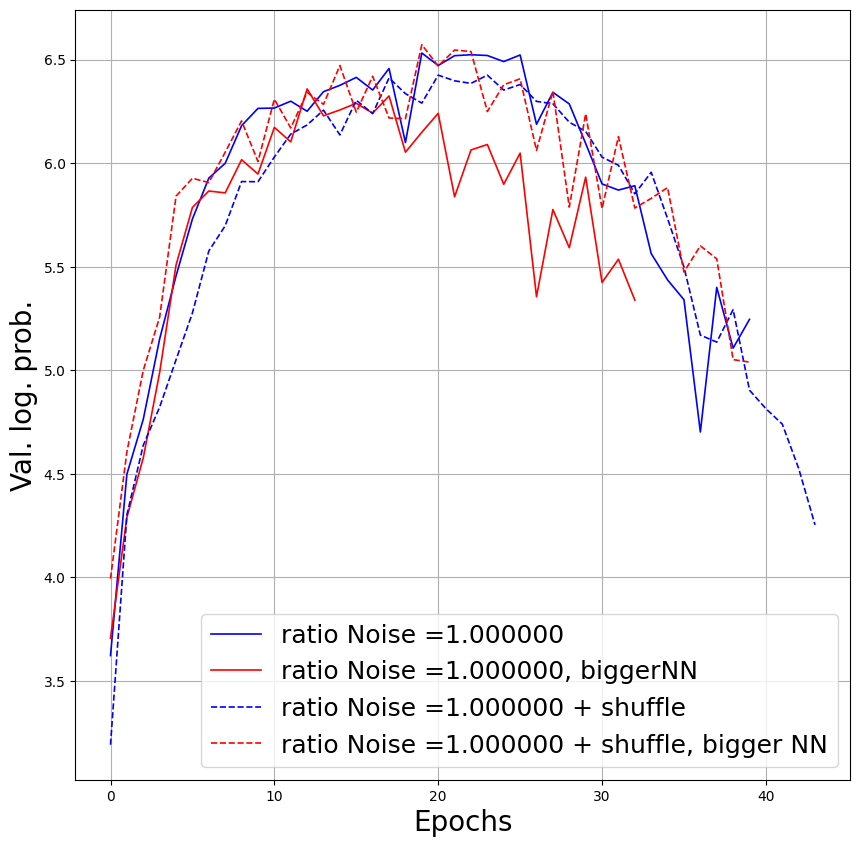

In [143]:
plt.figure(figsize=(10,10))
plt.plot(myInferenceNoiseM.summary["validation_log_probs"], linewidth=1.2, color = "blue", label = "ratio Noise =%f"%ratioNoiseM)
plt.plot(myInferenceNoiseMBig.summary["validation_log_probs"], linewidth=1.2, color = "red", label = "ratio Noise =%f, biggerNN"%ratioNoiseM)
plt.plot(myInferenceNoise_shM.summary["validation_log_probs"], linewidth=1.2, color = "blue",linestyle = "dashed", label = "ratio Noise =%f + shuffle"%ratioNoiseM)
plt.plot(myInferenceNoise_shMBig.summary["validation_log_probs"], linewidth=1.2, color = "red",linestyle = "dashed", label = "ratio Noise =%f + shuffle, bigger NN"%ratioNoiseM)
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Val. log. prob.",fontsize = 20)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 18, loc = "best")
plt.grid()

In [144]:
#%% Parametric model for the posterior
posteriorNoiseM = inferenceNoiseM.build_posterior(density_estimatorNoiseM)
posteriorNoiseS = inferenceNoiseS.build_posterior(density_estimatorNoiseS)
posteriorNoise_shM = inferenceNoise_shM.build_posterior(density_estimatorNoise_shM)
posteriorNoise_shS = inferenceNoise_shS.build_posterior(density_estimatorNoise_shS)

/usr/local/lib/python3.9/dist-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [147]:
# Let's pretend the observed data is the mean of my theoretical predictions
np.random.seed(890)
noise0S = np.random.multivariate_normal(np.pi*np.ones((dimNoiseS,)),np.pi/2.0 * np.eye(dimNoiseS))
noise0M = np.random.multivariate_normal(np.pi*np.ones((dimNoiseM,)),np.pi/2.0 * np.eye(dimNoiseM))
pk0NoiseS = torch.from_numpy(np.concatenate((pk0.cpu().numpy(),noise0S))).to(dtype = torch.float32, device = device)
pk0NoiseM = torch.from_numpy(np.concatenate((pk0.cpu().numpy(),noise0M))).to(dtype = torch.float32, device = device)

# Shuffled observation,careful!
pk0Noise_shS = copy.copy(pk0NoiseS.cpu().numpy())
np.random.seed(seedShuffle)
np.random.shuffle(pk0Noise_shS)

pk0Noise_shM = copy.copy(pk0NoiseM.cpu().numpy())
np.random.seed(seedShuffle)
np.random.shuffle(pk0Noise_shM)

posteriorNoiseS_samples = posteriorNoiseS.sample((100000,), x=pk0NoiseS)
posteriorNoiseM_samples = posteriorNoiseM.sample((100000,), x=pk0NoiseM)
posteriorNoise_shS_samples = posteriorNoise_shS.sample((100000,), x=torch.from_numpy(pk0Noise_shS).to(dtype = torch.float32, device = device))
posteriorNoise_shM_samples = posteriorNoise_shM.sample((100000,), x=torch.from_numpy(pk0Noise_shM).to(dtype = torch.float32, device = device))

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

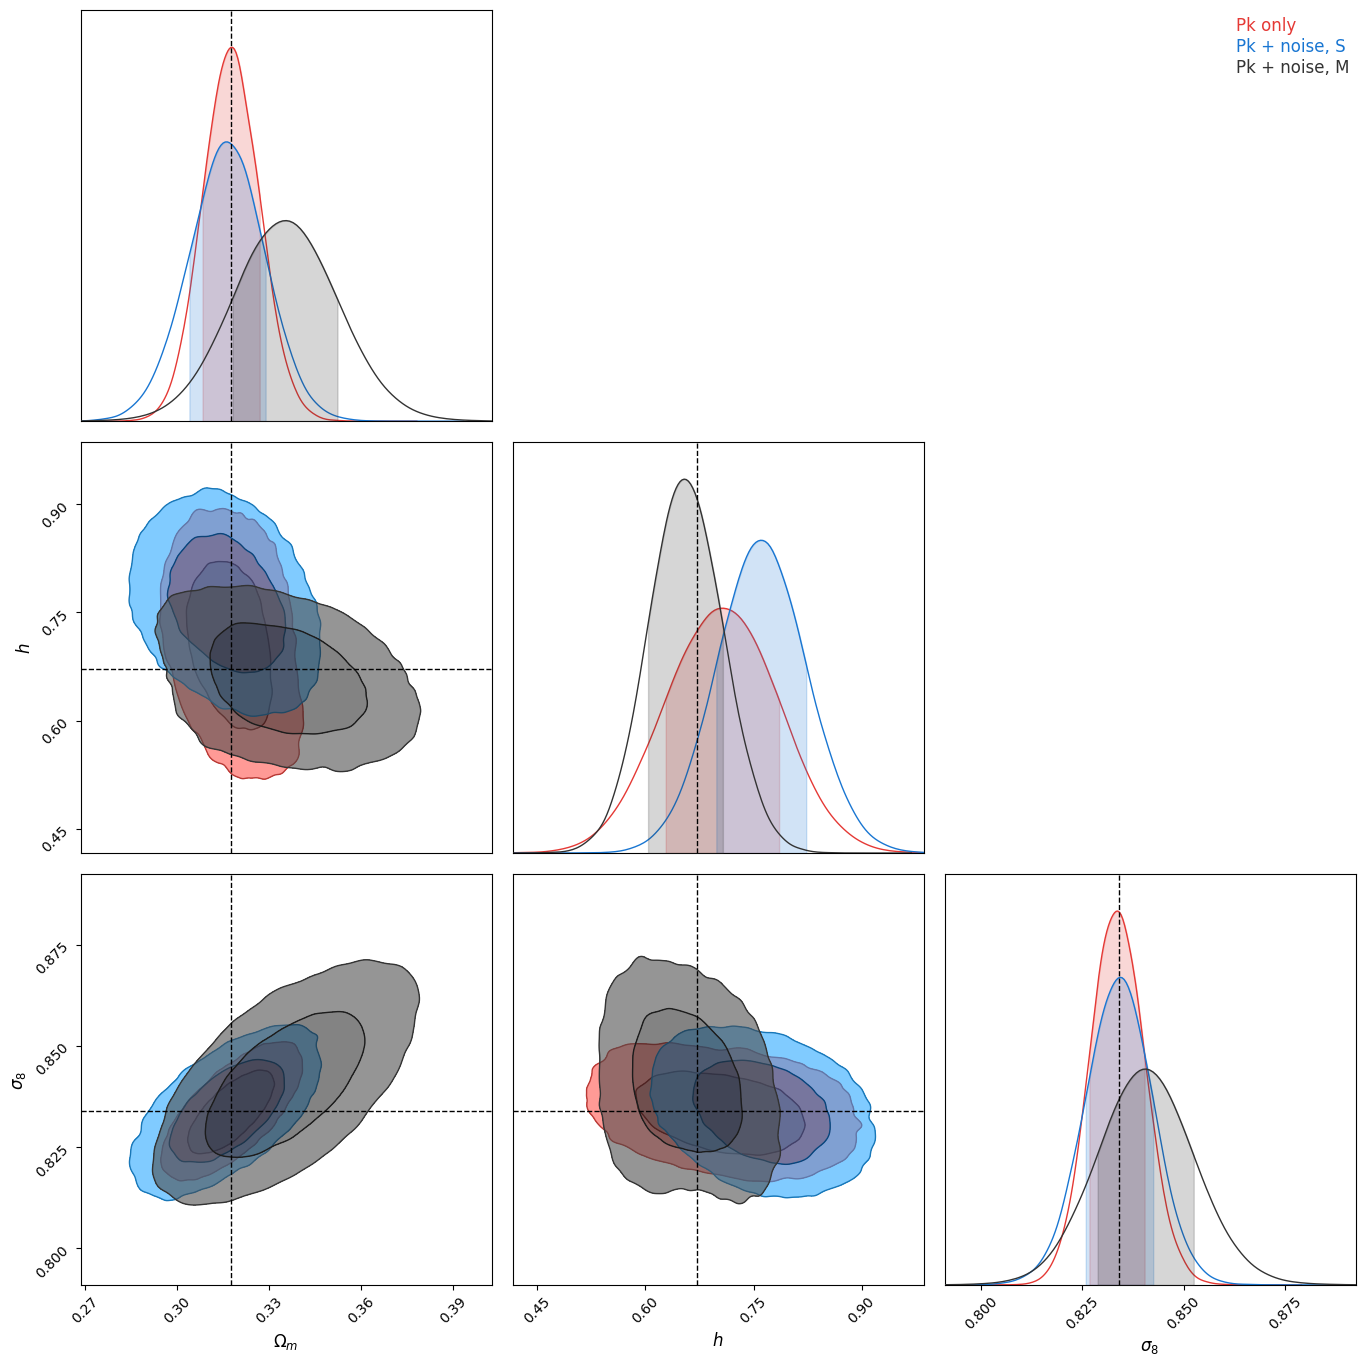

In [148]:
c2 = ChainConsumer()

c2.add_chain(posteriorU_samples.cpu().numpy(), parameters = chosenStr, name = "Pk only", zorder = 1, color = "red")
c2.add_chain(posteriorNoiseS_samples.cpu().numpy(), parameters = chosenStr, name = "Pk + noise, S", zorder = 2, color = "blue")
c2.add_chain(posteriorNoiseM_samples.cpu().numpy(), parameters = chosenStr, name = "Pk + noise, M", zorder = 3, color = "k")
figNew = c2.plotter.plot(figsize  =(15,15),truth=fiducial[res])

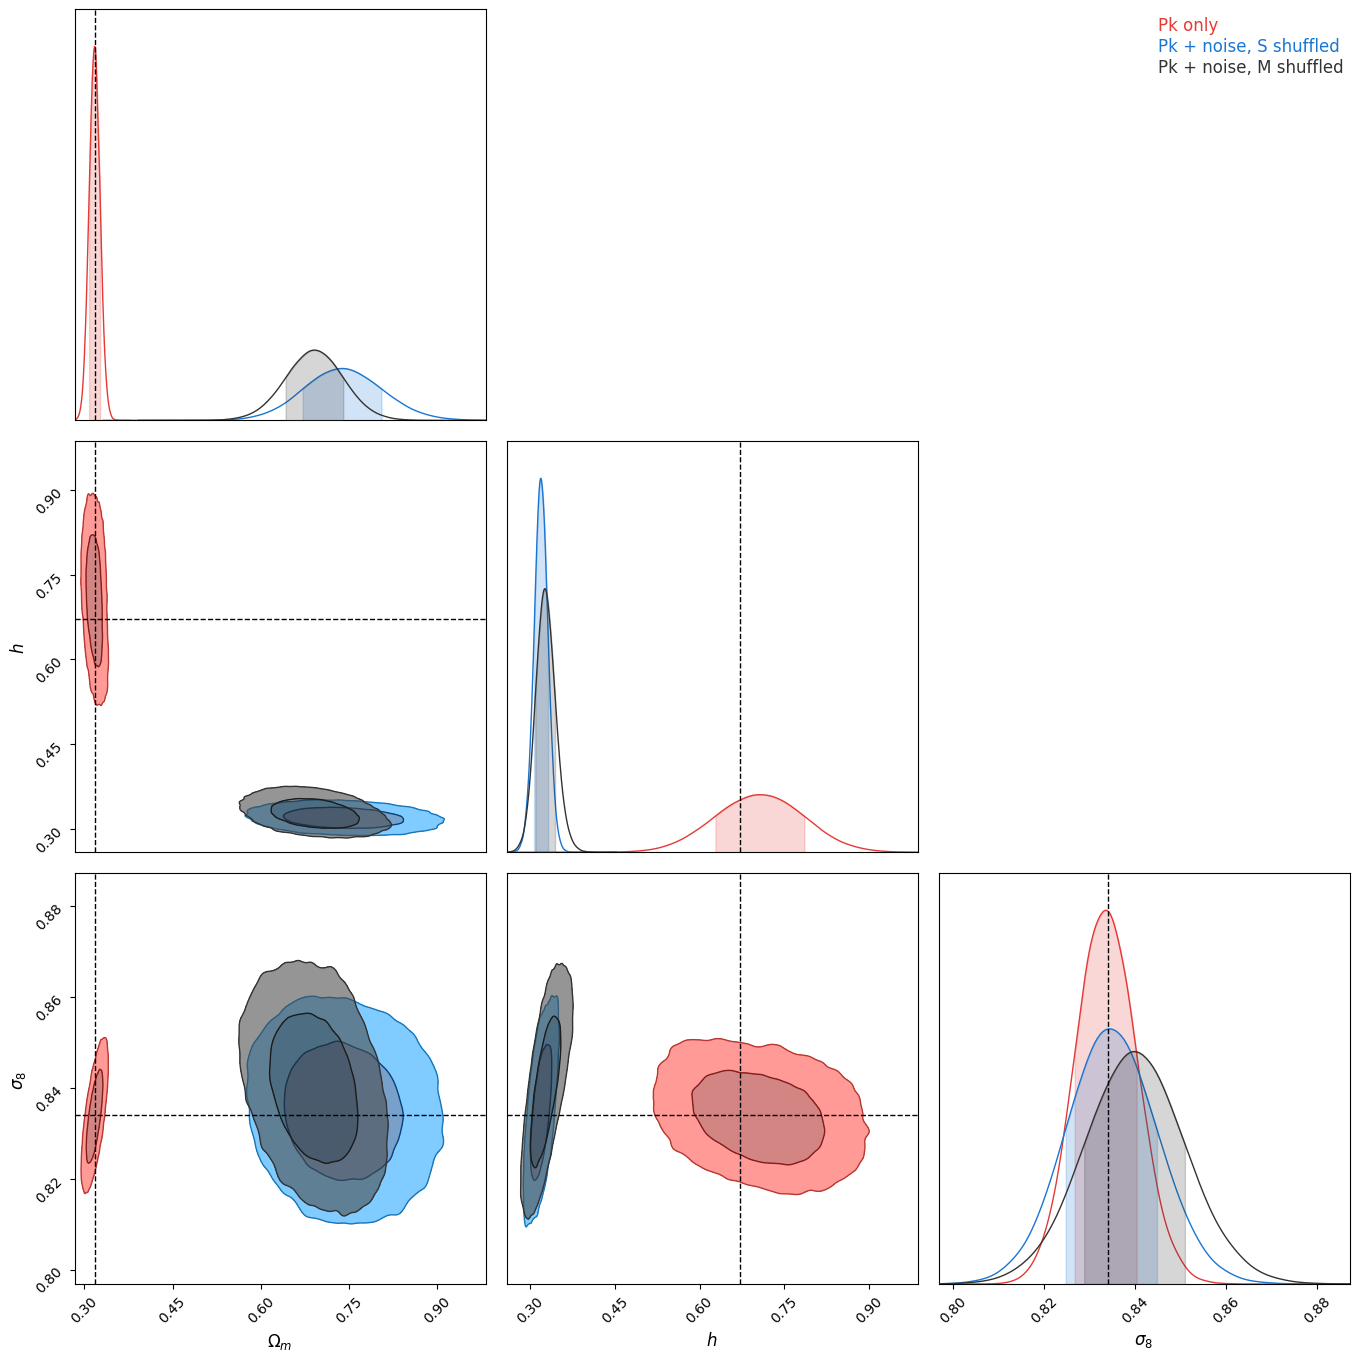

In [149]:
c3 = ChainConsumer()

c3.add_chain(posteriorU_samples.cpu().numpy(), parameters = chosenStr, name = "Pk only", zorder = 1, color = "red")
c3.add_chain(posteriorNoise_shS_samples.cpu().numpy(), parameters = chosenStr, name = "Pk + noise, S shuffled", zorder = 2, color = "blue")
c3.add_chain(posteriorNoise_shM_samples.cpu().numpy(), parameters = chosenStr, name = "Pk + noise, M shuffled", zorder = 3, color = "k")
figRe = c3.plotter.plot(figsize  =(15,15),truth=fiducial[res])

# New Section